In [1]:
import warnings
warnings.filterwarnings("ignore")
from ucimlrepo import fetch_ucirepo 
heart_disease = fetch_ucirepo(id=45)  
X = heart_disease.data.features 
y = heart_disease.data.targets 

Data types check:

In [2]:
X.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object

In [3]:
y.dtypes

num    int64
dtype: object

Variables aren't correctly read

In [4]:
for i in [1,2,5,6,8,10,12]:
  X[X.columns[i]]=X[X.columns[i]].astype("category")

In [5]:
X.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
dtype: object

Initially the data presents a scale of how strong is the diseas (1, 2, 3, 4). As stated in the data repository the aim is to only detect the presence of the disease, hence the target variable needs to be converted into a binary (1,0). 

In [6]:
import pandas as pd
for i in range(len(y["num"])):
  if y["num"][i] in [1,2,3,4]:
    y["num"][i]=1
  else:
    y["num"][i]=0

In [7]:
y["num"].value_counts()

num
0    164
1    139
Name: count, dtype: int64

Target Variable Study

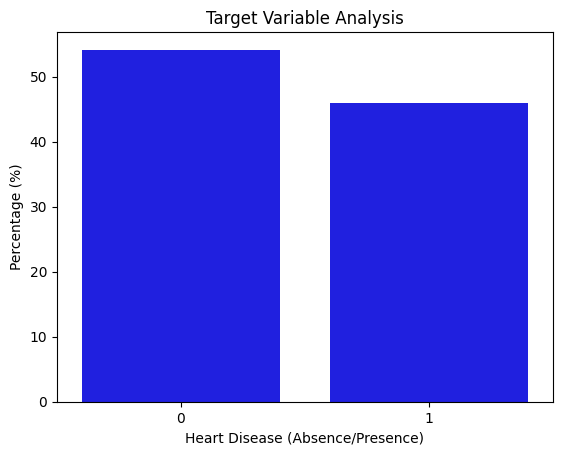

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

percentages = (y["num"].value_counts() * 100) / len(y)
sns.barplot(x=percentages.index, y=percentages.values, color="b")

plt.title("Target Variable Analysis")
plt.xlabel("Heart Disease (Absence/Presence)")
plt.ylabel("Percentage (%)")
plt.show()

In [9]:
round(((y["num"].value_counts() * 100) / len(y)),3)

num
0    54.125
1    45.875
Name: count, dtype: float64

The target isn't unbalanced

Categorical Variables Study

In [10]:
cat=X.select_dtypes(include="category")
cat.dtypes

sex        category
cp         category
fbs        category
restecg    category
exang      category
slope      category
thal       category
dtype: object

In [11]:
round((y[y["num"] == 1].value_counts()*100)/len(y),3)

num
1      45.875
Name: count, dtype: float64

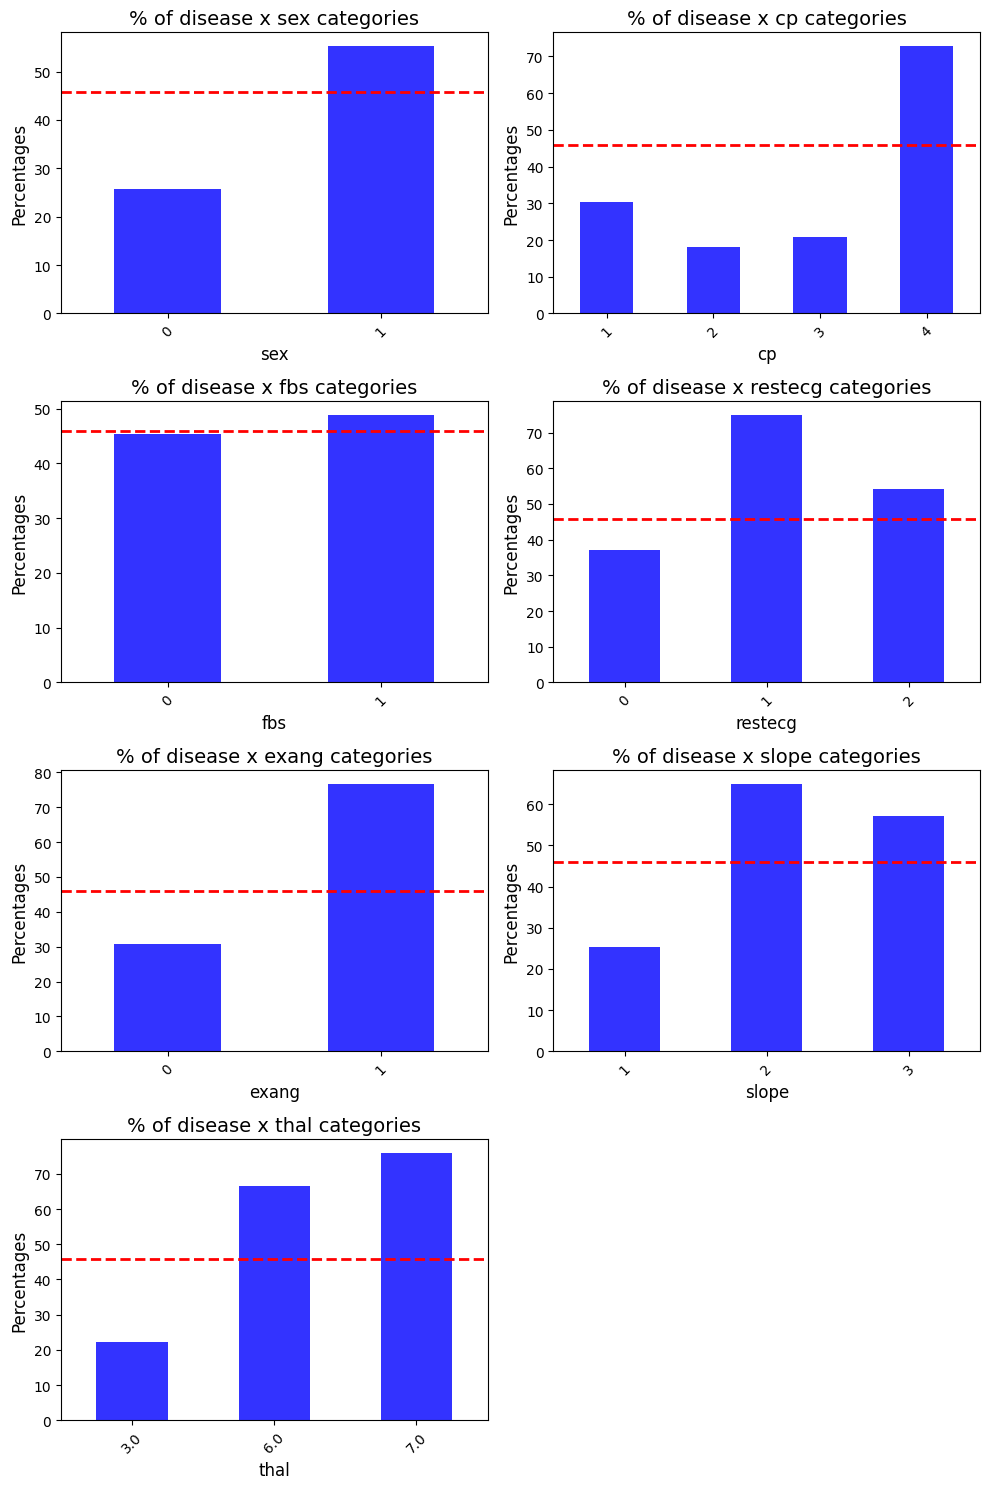

In [12]:
import matplotlib.pyplot as plt
import numpy as np

colplot = cat.columns

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()

for i, column in enumerate(colplot):
    ax = axes[i]
    
    ((y[y["num"] == 1].groupby(cat[column]).size() * 100) / (cat.groupby(cat[column]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
    ax.axhline(y=45.875, color="r", linestyle="--", linewidth=2, label="Threshold 45.875")

    
    ax.set_title(f"% of disease x {column} categories", fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Percentages", fontsize=12)
    ax.tick_params(axis="x", rotation=45)

 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  

plt.tight_layout()
plt.show()

Based on the bar analysis all the variables should  be explicative of the target, with the exception of "fbs". To be sure about this a Chi-Square test is performed. 

In [13]:
from scipy.stats import chi2_contingency

y["num"]=y["num"].astype("category")
contingency_table = pd.crosstab(cat["sex"],y["num"])
p= chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: Chi2ContingencyResult(statistic=np.float64(22.042560606155472), pvalue=np.float64(2.666712348180942e-06), dof=1, expected_freq=array([[ 52.50165017,  44.49834983],
       [111.49834983,  94.50165017]]))


In [14]:
import pandas as pd
from scipy.stats import chi2_contingency

y["num"] = y["num"].astype("category")

p_values = []

for column in cat.columns:
    contingency_table = pd.crosstab(cat[column], y["num"])
    chi2, p, dof, expected= chi2_contingency(contingency_table)
    p_values.append(p)

p_values_df = pd.DataFrame(p_values, index=cat.columns, columns=["p-value"])
print(p_values_df)

              p-value
sex      2.666712e-06
cp       1.251711e-17
fbs      7.812734e-01
restecg  6.566524e-03
exang    1.413788e-13
slope    1.142885e-10
thal     8.201820e-19


Chi-Square confirms what was seen in the previous charts. "fbs" has a p-value>0.05, this means there isn't a significant relation with the target variable.

Numeric Variables Analysis

In [15]:
num=X.select_dtypes("number")
num.dtypes

age           int64
trestbps      int64
chol          int64
thalach       int64
oldpeak     float64
ca          float64
dtype: object

In [16]:
num["num"] = y["num"].astype("int64") 
corr=num.corr()
corr.style.background_gradient(cmap="coolwarm")

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.362605,0.223120
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.098773,0.150825
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.119000,0.085164
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.264246,-0.417167
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.295832,0.424510
ca,0.362605,0.098773,0.119000,-0.264246,0.295832,1.000000,0.460442
num,0.223120,0.150825,0.085164,-0.417167,0.424510,0.460442,1.000000


Before making any kind of decision based uniquely on the correlation , it's better to have a second opinion. For these reason the variables can be divided in bins and compered to the target variables as it was made before with the categorical variables.

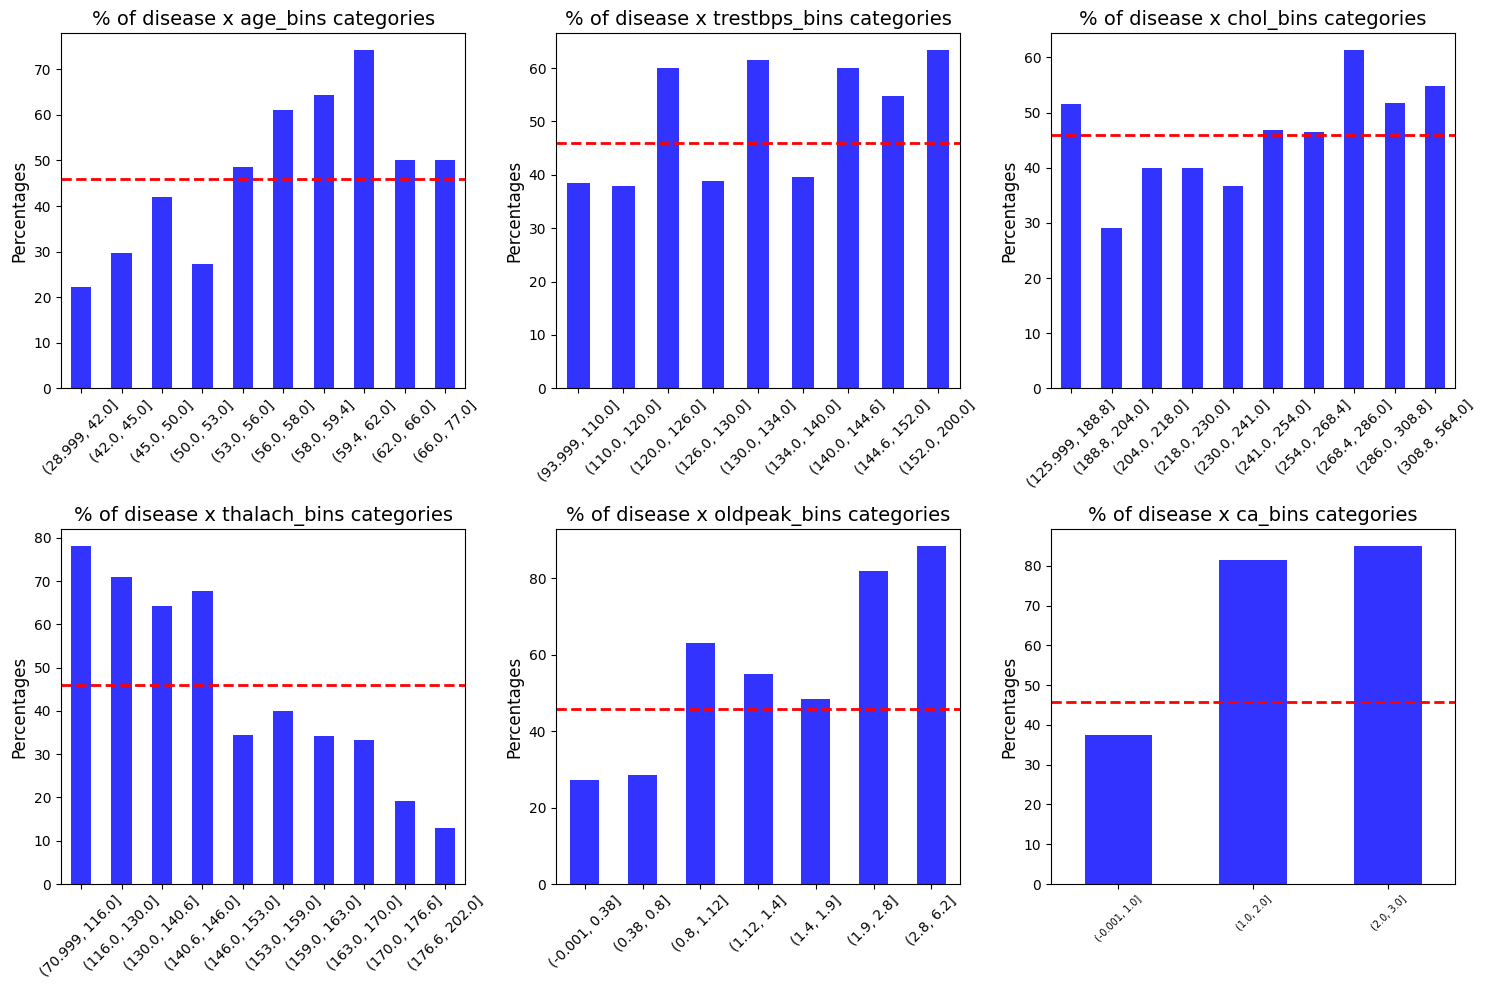

In [17]:
numbin=num.copy()
numbin=numbin.drop("num",axis=1)
colbin= numbin.columns

fig,axes=plt.subplots(2,3,figsize=(15,10))
axes=axes.flatten()

for i, column in enumerate(colbin):
    ax = axes[i]
    numbin[f"{column}_bins"]=pd.qcut(numbin[column],q=10,duplicates="drop")

    ((y[y["num"] == 1].groupby(numbin[f"{column}_bins"]).size() * 100) / (numbin.groupby(numbin[f"{column}_bins"]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
    ax.axhline(y=45.875, color="r", linestyle="--", linewidth=2, label="Threshold 45.875")

    
    ax.set_title(f"% of disease x {column}_bins categories", fontsize=14)
    ax.set_xlabel(None)
    ax.set_ylabel("Percentages", fontsize=12)
    plt.xticks(fontsize=7)
    ax.tick_params(axis="x", rotation=45)
    
plt.subplots_adjust(hspace=0.4, wspace=0.4)  
plt.tight_layout()

plt.show()


"trestbps" and "chol" have both a low correlation to the target and when divided into bins and compared to the percentage of having the hart disease they don't present a clear pattern. For this reasons they can be exluded.

In [18]:
num=num.drop(["trestbps","chol"],axis=1)
corr = num.corr()
masked_corr =corr.where((corr < -0.8) | (corr > 0.8))
masked_corr.style.background_gradient(cmap='coolwarm', axis=None).format("{:.2f}")

,age,thalach,oldpeak,ca,num
age,1.00,nan,nan,nan,nan
thalach,nan,1.00,nan,nan,nan
oldpeak,nan,nan,1.00,nan,nan
ca,nan,nan,nan,1.00,nan
num,nan,nan,nan,nan,1.00


There is no clear evidence of multicollinearity